In [1]:
from models import MeshModel, IcosphereModel
import jax.numpy as jnp
from jax.typing import ArrayLike
from models.mesh_transform import add_rotation, evaluate_rotation
from plots import plot_3D
from spectrum import simulate_spectrum, blackbody_intensity

In [2]:
jnp.log10(5700)

Array(3.7558744, dtype=float32)

In [3]:
m = IcosphereModel.construct(1000, 1., 1., 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)]))

1
[3.75 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.  ]


In [4]:
mt = add_rotation(m, 1000.)

In [5]:
mt1 = evaluate_rotation(mt, 0)

In [6]:
jnp.max(mt1.los_velocities)

Array(987.57904, dtype=float32)

In [7]:
jnp.max(mt1.velocities)

Array(992.7091, dtype=float32)

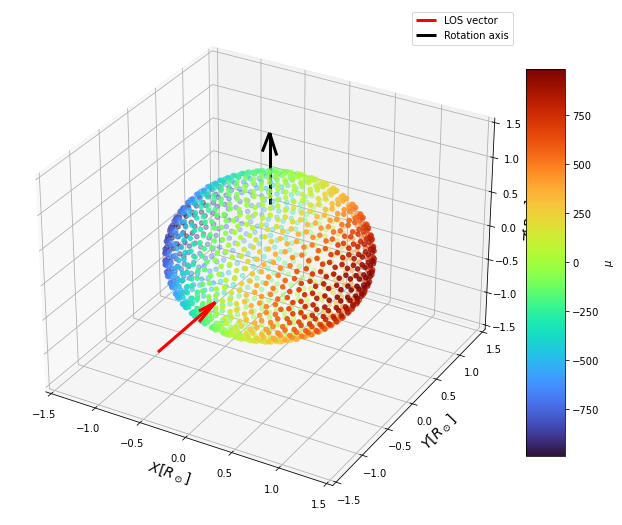

In [8]:
plot_3D(mt1, 'los_velocities')

In [9]:
mt1.parameters.shape

(1280, 20)

In [13]:
i = simulate_spectrum(blackbody_intensity, mt1, jnp.log10(jnp.linspace(1000., 20000., 100)))

In [14]:
import matplotlib.pyplot as plt

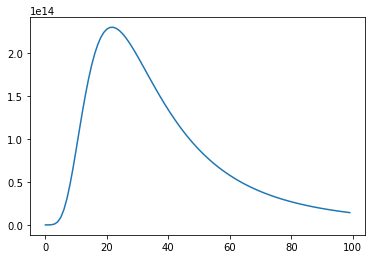

In [15]:
plt.plot(i[:, 0])